# Assignment 05
The goal of this assignment is to build a simple, modular, extensible, machine learning pipeline in Python. The problem is to predict if a project on donorschoose will not get fully funded within 60 days of posting.

The data set below is a modified version of data from https://www.kaggle.com/c/GiveMeSomeCredit

### Setup

In [0]:
from google.colab import drive

In [0]:
# delete
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
pip install geopandas

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd "gdrive/My Drive/ML"

[Errno 2] No such file or directory: 'gdrive/My Drive/ML'
/content/gdrive/My Drive/ML


In [0]:
ls

 classifiers.py      'Large - ML_pipeline.ipynb'   results/
 data/               'Med -  ML_pipeline.ipynb'
 data_processing.py   __pycache__/


In [0]:
import data_processing as dp
import classifiers as cfs

### Parameters
The following are the parameters used to analyze this specific dataset. If modified, the user might have to run the whole code again.

In [0]:
PARAMS = {
          'seed': 2222,
          'data_filepath': "data/projects_2012_2013.csv",
          'var_types': {'projectid':str,
                        'teacher_acctid':str,
                        'schoolid':str,
                        'school_ncesid':str,
                        'school_latitude':float, 
                        'school_longitude':float},
          'geometry': {"long": "school_longitude",
                       "lat": "school_latitude"},
          'id_cols': ['projectid',
                      'teacher_acctid',
                      'schoolid',
                      'school_ncesid'],
          'date_cols': ["date_posted",
                        "datefullyfunded"],
          'test_size': 0.3,
          'preciction_gap': 60, # days
          'target_feature': 'not_funded_within_60days',
          'train_len': 365//2, # days
          'grid_size': 'small',
          # size of the grid to run the models. Only run large when sure about
          # the functionality, as it will be computationally expensive
          'thresholds': [1, 2, 5, 10, 20, 30, 50]
}

## 1) Load Data

In [0]:
df = dp.get_projects_df(PARAMS['data_filepath'])
# original_gdf = dp.get_gdf(original_df, PARAMS['geometry']['long'], PARAMS['geometry']['lat'])
# ids_df = dp.get_ids_df(original_gdf, PARAMS['id_cols'])

Converting datefullyfunded to datetime
Converting date_posted to datetime
Converting school_charter to binary
Converting school_magnet to binary
Converting eligible_double_your_impact_match to binary
Created binary col female_teacher and dropped teachers_prefix



In [0]:
df.shape

(124976, 27)

In [0]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded',
       'female_teacher', 'not_funded_within_60days'],
      dtype='object')

In [0]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,school_charter,school_magnet,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,female_teacher,not_funded_within_60days
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.70993E+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,Cook,False,False,Mathematics,Math & Science,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,False,2013-04-14,2013-05-02,True,False
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,64098006751,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,Ventura,False,False,Civics & Government,History & Civics,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,True,2012-04-07,2012-04-18,True,False
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,62271003143,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,Los Angeles,False,False,Literacy,Literacy & Language,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,False,2012-01-30,2012-04-15,True,True
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.60009E+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,Kings (Brooklyn),False,True,Literacy,Literacy & Language,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,False,2012-10-11,2012-12-05,True,False
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.60687E+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,Suffolk,False,False,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,False,2013-01-08,2013-03-25,True,True


### 1.1 Create outcome variable

In [0]:
dp.create_period_outcome(df, initial_date=PARAMS['date_cols'][0], end_date=PARAMS['date_cols'][1])
# set in the PARAMS dictionary the name of the outcome feature
PARAMS['target'] = dp.get_outcome_lbl()

Created outcome feature: not_funded_within_60days
count     124976
unique         2
top        False
freq       88966
Name: not_funded_within_60days, dtype: object


## 2) Explore Data

### 2.1 Sumary of data

In [0]:
dp.describe_data(df, PARAMS['date_cols'])

Number of obs: 124976

Columns with missing data: ['school_ncesid', 'school_metro', 'school_district', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'grade_level', 'students_reached']

Description of numeric features:

       school_latitude  ...  students_reached
count    124976.000000  ...     124917.000000
mean         36.827284  ...         95.445760
std           4.963669  ...        163.481912
min          18.249140  ...          1.000000
25%          33.872504  ...         23.000000
50%          36.617410  ...         30.000000
75%          40.676156  ...        100.000000
max          65.672562  ...      12143.000000

[8 rows x 4 columns]

Description of date columns:

Date column date_posted
count                  124976
unique                    731
top       2012-09-30 00:00:00
freq                      728
first     2012-01-01 00:00:00
last      2013-12-31 00:00:00
Name: date_posted, dtype: object

Date co

In [0]:
dp.view_data(df)

## 4) Generate and process temporal validation sets

In [0]:
temporal_dfs = dp.get_temporal_dfs(df=df,
                                   d_col=PARAMS['date_cols'][0],
                                   target_col=PARAMS['target_feature'],
                                   prediction_gap=PARAMS['preciction_gap'],
                                   pred_win_len=PARAMS['train_len'],
                                   print_tab=' ')

Creating binary columns: ['grade_level', 'poverty_level', 'primary_focus_area', 'resource_type', 'school_metro', 'secondary_focus_area']
 		 Creating dummies for ['grade_level', 'poverty_level', 'primary_focus_area', 'resource_type', 'school_metro', 'secondary_focus_area']

Complete data set has 124976 obs and 58 variables

Working with train/test set split at: 2012-07-01 00:00:00
the train dict end date is:  2012-05-02 00:00:00
Working with train df
 Filling missing values...
	Filling missing values for numeric col: total_price_including_optional_support
	Filling missing values for numeric col: students_reached

 Discretizing continous columns...
	Discretizing var: total_price_including_optional_support
	Discretizing var: students_reached

 Creating missing binary columns of just created discretized columns...
 Creating dummies for ['total_price_including_optional_support_discrete', 'students_reached_discrete']
 		 Train DF starts at 2012-01-01 00:00:00, ends at 2012-05-02 00:00:00, h

/content/gdrive/My Drive/ML/data_processing.py:478: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = df[df[d_col] >= test_start_d][df[d_col] <= test_end_d]\


Working with train df
 Filling missing values...
	Filling missing values for numeric col: total_price_including_optional_support
	Filling missing values for numeric col: students_reached

 Discretizing continous columns...
	Discretizing var: total_price_including_optional_support
	Discretizing var: students_reached

 Creating missing binary columns of just created discretized columns...
 Creating dummies for ['total_price_including_optional_support_discrete', 'students_reached_discrete']
 		 Train DF starts at 2012-01-01 00:00:00, ends at 2012-10-31 00:00:00, has 49680 obs and 68 cols

Working with test df
 Filling missing values...
	Filling missing values for numeric col: total_price_including_optional_support
	Filling missing values for numeric col: students_reached

 Discretizing continous columns...
	Discretizing var: total_price_including_optional_support
	Discretizing var: students_reached

 Creating missing binary columns of just created discretized columns...
 Creating dummies 

## 5) Get models and grid, and train

In [0]:
results_med = cfs.run_clfs('med', PARAMS['thresholds'], temporal_dfs)

In [0]:
results_med = pd.read_csv('results/grid_med_time_00_25_40results.csv')

In [0]:
results_med.head()

,Unnamed: 0,model_type,clf_details,chosen_params,split_date,start_date_train,end_date_train,start_date_test,end_date_test,random_baseline,p_at_1pct,recall_at_1pct,f1_at_1pct,p_at_2pct,recall_at_2pct,f1_at_2pct,p_at_5pct,recall_at_5pct,f1_at_5pct,p_at_10pct,recall_at_10pct,f1_at_10pct,p_at_20pct,recall_at_20pct,f1_at_20pct,p_at_30pct,recall_at_30pct,f1_at_30pct,p_at_50pct,recall_at_50pct,f1_at_50pct,auc-roc
0,0,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.004348,0.000174,0.000335,0.140998,0.011328,0.020971,0.310494,0.062391,0.103904,0.201648,0.081039,0.115614,0.318300,0.255838,0.283671,0.285487,0.344197,0.312105,0.292516,0.587835,0.390642,0.576174
1,1,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.365217,0.014639,0.028150,0.357918,0.028756,0.053234,0.348656,0.070059,0.116674,0.361665,0.145347,0.207360,0.362316,0.291216,0.322899,0.349668,0.421575,0.382269,0.333969,0.671140,0.446002,0.644003
2,2,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.456522,0.018299,0.035188,0.470716,0.037818,0.070011,0.410234,0.082433,0.137281,0.398092,0.159986,0.228245,0.366002,0.294179,0.326184,0.348367,0.420007,0.380847,0.335183,0.673580,0.447623,0.650081
3,3,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.443478,0.017776,0.034182,0.453362,0.036424,0.067430,0.423244,0.085047,0.141634,0.385082,0.154758,0.220786,0.366219,0.294353,0.326377,0.348077,0.419658,0.380531,0.334837,0.672883,0.447160,0.650987
4,4,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.013043,0.000523,0.001005,0.006508,0.000523,0.000968,0.002602,0.000523,0.000871,0.297918,0.119728,0.170811,0.278621,0.223946,0.248309,0.342440,0.412862,0.374368,0.312982,0.628965,0.417974,0.606404


## 6) Analyze models

In [0]:
results_med.shape

(558, 32)

### Per type of model

#### Overall higher precision

In [0]:
overall = results_med.groupby(['model_type'])\
           .agg({'p_at_5pct': np.median})\
          .sort_values('p_at_5pct', ascending = False)
overall

,p_at_5pct
model_type,
SVM,0.467649
LR,0.465414
RF,0.397630
KNN,0.352979
B,0.340809
GB,0.322214
DT,0.204675


#### By splits

In [0]:
split_dates = [['first', '2012-07-01'],
               ['second', '2012-12-30'],
               ['third', '2013-06-30']]

In [0]:
for split, date in split_dates:
  print(split, date)
  tbl = results_med[results_med.split_date == date]\
              .groupby(['model_type'])\
              .agg({'p_at_5pct': np.median,
                  'recall_at_5pct': np.median,
                  'auc-roc': np.median})\
              .sort_values('p_at_5pct', ascending = False)
  print(tbl)
  print()

First split date 2012-07-01
            p_at_5pct  recall_at_5pct   auc-roc
model_type                                     
SVM          0.468343        0.094109  0.654871
LR           0.466175        0.093674  0.654779
RF           0.355160        0.071366  0.621376
KNN          0.325239        0.065354  0.567840
B            0.319601        0.064221  0.580876
GB           0.276670        0.055594  0.609952
DT           0.001301        0.000261  0.567701

Second split date 2012-12-30
            p_at_5pct  recall_at_5pct   auc-roc
model_type                                     
SVM          0.537649        0.090044  0.680564
LR           0.532365        0.089159  0.680242
RF           0.462351        0.077434  0.642693
KNN          0.404227        0.067699  0.583294
GB           0.396962        0.066482  0.652213
B            0.373184        0.062500  0.596414
DT           0.192206        0.032190  0.588109

Third split date 2013-06-30
            p_at_5pct  recall_at_5pct   auc-roc
m

### Best classifiers

In [0]:
best_cfs = []
for split, date in split_dates:
  split_df = results_med[results_med.split_date == date]
  split_df = split_df[['model_type','p_at_5pct', 'chosen_params']].sort_values('p_at_5pct', ascending = False)
  split_df['rank_{}'.format(split)] = split_df['p_at_5pct'].rank(ascending=False).head(50)
  best_cfs.append(split_df)

In [0]:
best_cfs[0]

,model_type,p_at_5pct,chosen_params,rank_first
52,SVM,0.480486,{'C': 10},1.0
50,SVM,0.478751,{'C': 0.1},2.0
44,LR,0.477884,"{'C': 10, 'penalty': 'l1'}",3.5
45,LR,0.477884,"{'C': 10, 'penalty': 'l2'}",3.5
42,LR,0.477016,"{'C': 1, 'penalty': 'l1'}",5.0
...,...,...,...,...
138,DT,0.000000,"{'criterion': 'entropy', 'max_depth': 1, 'max_...",NaN
85,DT,0.000000,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",NaN
36,LR,0.000000,"{'C': 1e-05, 'penalty': 'l1'}",NaN
38,LR,0.000000,"{'C': 0.001, 'penalty': 'l1'}",NaN


In [0]:
first_split = best_cfs[0].rename(columns={'p_at_5pct': "p_at_5pct_first"})
second_split = best_cfs[1].rename(columns={'p_at_5pct': "p_at_5pct_second"})
third_split = best_cfs[2].rename(columns={'p_at_5pct': "p_at_5pct_third"})

In [0]:
third_split.head(5)

,model_type,p_at_5pct_third,chosen_params,rank_third
432,GB,0.472133,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.0
413,LR,0.470211,"{'C': 0.1, 'penalty': 'l2'}",2.0
420,SVM,0.467649,{'C': 0.001},3.0
412,LR,0.467008,"{'C': 0.1, 'penalty': 'l1'}",4.0
415,LR,0.465086,"{'C': 1, 'penalty': 'l2'}",5.5


In [0]:
ranks = first_split.merge(second_split, how='inner', on=['model_type', 'chosen_params'])\
                   .merge(third_split, how='inner', on=['model_type', 'chosen_params'])
ranks['sum_ranks'] = ranks['rank_first'] + ranks['rank_second'] + ranks['rank_third']
ranks['median_ranks'] = np.median(ranks[['rank_first', 'rank_second','rank_third']], axis=1) 
ranks.sort_values('median_ranks', ascending = True).head(5)

,model_type,p_at_5pct_first,chosen_params,rank_first,p_at_5pct_second,rank_second,p_at_5pct_third,rank_third,sum_ranks,median_ranks
0,SVM,0.480486,{'C': 10},1.0,0.546896,1.0,0.458680,12.5,14.5,1.0
1,SVM,0.478751,{'C': 0.1},2.0,0.541612,2.5,0.458680,12.5,17.0,2.5
17,GB,0.421509,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",18.5,0.540291,4.0,0.472133,1.0,23.5,4.0
4,LR,0.477016,"{'C': 1, 'penalty': 'l1'}",5.0,0.535007,7.0,0.465086,5.5,17.5,5.5
5,SVM,0.476149,{'C': 1},6.0,0.541612,2.5,0.459321,11.0,19.5,6.0


In [0]:
models_and_params = ranks.sort_values('median_ranks', ascending = True).head(5)
models_and_params = models_and_params[['model_type','chosen_params']]
best_5_to_plot = pd.DataFrame(columns=['model_type', 'chosen_params', 'p_at_5pct', 'split_date'])
for i, split in enumerate(best_cfs):
  best_5 = models_and_params.merge(split)
  best_5['split_date'] = split_dates[i][1]
  best_5 = best_5[['model_type', 'chosen_params', 'p_at_5pct', 'split_date']]
  best_5_to_plot = best_5_to_plot.append(best_5)

In [0]:
best_5_to_plot["model"] = best_5_to_plot.model_type + " params: " + best_5_to_plot.chosen_params
best_5_to_plot.drop(columns=['model_type', 'chosen_params'], inplace=True)

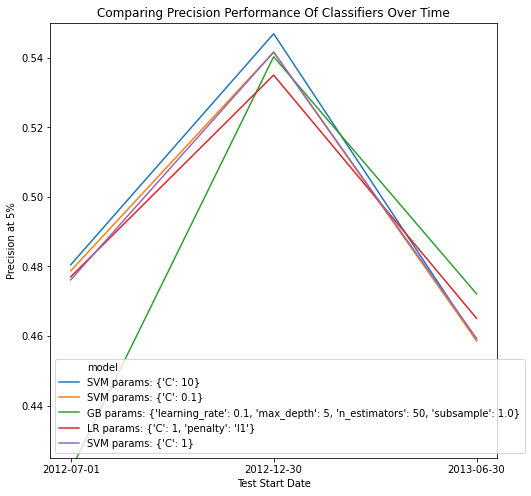

In [0]:
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x="split_date", y="p_at_5pct", hue="model",
             data=best_5_to_plot, ax=ax)
ax.set_ylim(0.425, 0.55)
ax.set_xlabel("Test Start Date")
ax.set_ylabel("Precision at 5%")
ax.set_title("Comparing Precision Performance Of Classifiers Over Time (with median rank)")
plt.savefig('results/figures/cfs_precision_over_time.png')
plt.show()

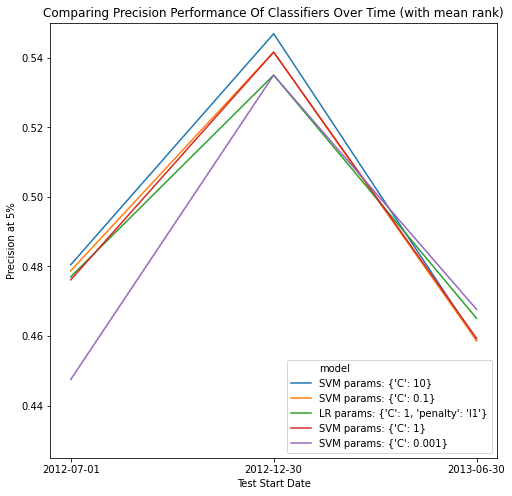

In [0]:
models_and_params = ranks.sort_values('sum_ranks', ascending = True).head(5)
models_and_params = models_and_params[['model_type','chosen_params']]
best_5_to_plot = pd.DataFrame(columns=['model_type', 'chosen_params', 'p_at_5pct', 'split_date'])
for i, split in enumerate(best_cfs):
  best_5 = models_and_params.merge(split)
  best_5['split_date'] = split_dates[i][1]
  best_5 = best_5[['model_type', 'chosen_params', 'p_at_5pct', 'split_date']]
  best_5_to_plot = best_5_to_plot.append(best_5)

best_5_to_plot["model"] = best_5_to_plot.model_type + " params: " + best_5_to_plot.chosen_params
best_5_to_plot.drop(columns=['model_type', 'chosen_params'], inplace=True)

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x="split_date", y="p_at_5pct", hue="model",
             data=best_5_to_plot, ax=ax)
ax.set_ylim(0.425, 0.55)
ax.set_xlabel("Test Start Date")
ax.set_ylabel("Precision at 5%")
ax.set_title("Comparing Precision Performance Of Classifiers Over Time (with mean rank)")
plt.savefig('results/figures/cfs_precision_over_time.png')
plt.show()

### Plot

Selecting the specific model with the highest precision for each type of model.

In [0]:
summary = pd.pivot_table(results_med,
                         index=['model_type', 'split_date'],
                         aggfunc='max',
                         fill_value=0)
clean_summary = summary[['chosen_params', 'p_at_5pct']]

In [0]:
clean_summary.chosen_params.unique()

array(["{'n_estimators': 1}",
       "{'criterion': 'gini', 'max_depth': 50, 'max_features': None, 'min_samples_split': 5}",
       "{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}",
       "{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}",
       "{'C': 1e-05, 'penalty': 'l2'}",
       "{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1}",
       "{'C': 1}"], dtype=object)

In [0]:
results_to_plot = summary.reset_index()[['model_type', 'split_date', 'p_at_5pct']]

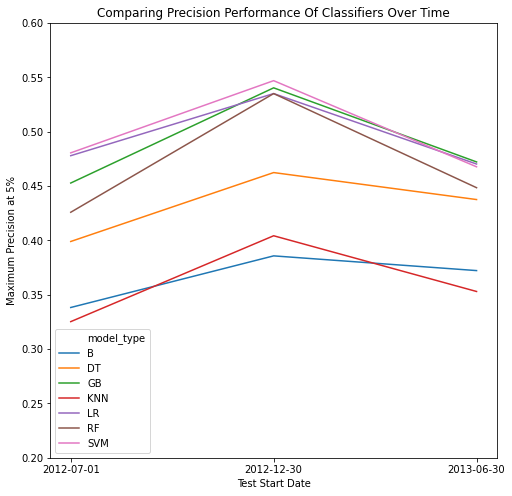

In [0]:
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x="split_date", y="p_at_5pct", hue="model_type",
             data=results_to_plot, ax=ax)
ax.set_ylim(0.2, 0.6)
ax.set_xlabel("Test Start Date")
ax.set_ylabel("Maximum Precision at 5%")
ax.set_title("Comparing Precision Performance Of Classifiers Over Time")
plt.savefig('results/figures/precision_over_time.png')
plt.show()